In [196]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")


In [197]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [198]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


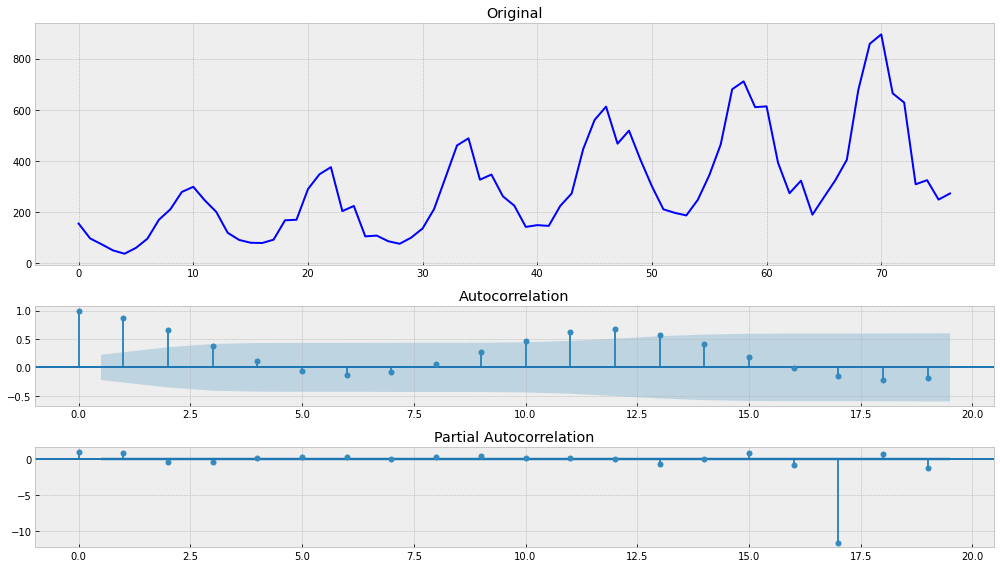

In [199]:
df = pd.read_csv("Series\monthly-sales-of-company-x-jan-6.csv")['Count']
tsplot(df)

Преобразуем ряд в стационарный

Results of Dickey-Fuller Test:
Test Statistic                -9.978030e+00
p-value                        2.151489e-17
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


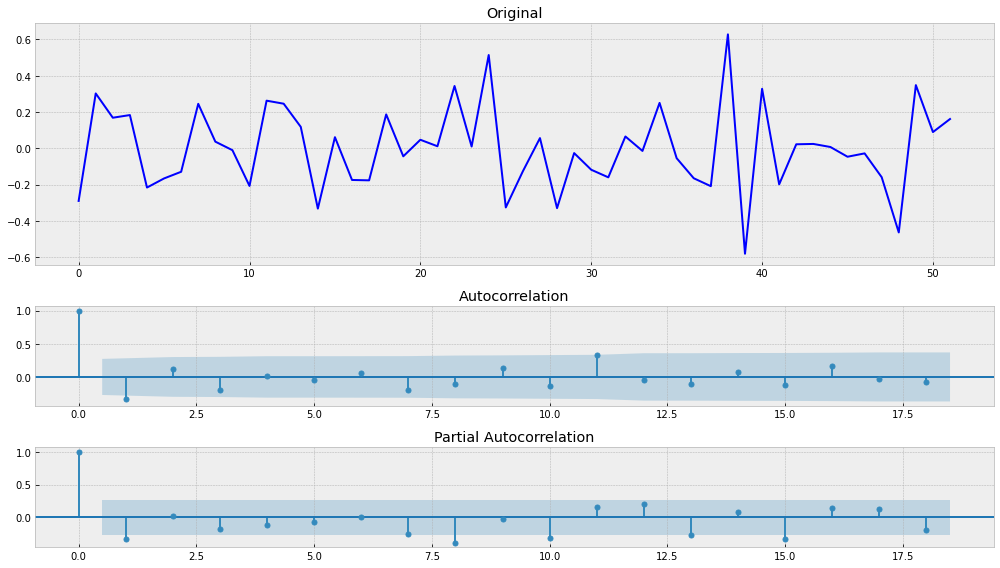

In [200]:
series = boxcox(df, 0)
series = series[1:] - series[:-1]
series = series[24:] - series[:-24]
tsplot(series)

In [201]:
N_pred = 15
train = series[:-N_pred]
test = series[-N_pred:]

Ищем оптимальные параметры

In [202]:
best_mse = float('inf')
best_order = None
best_arm = None
for i in range(15):
    for d in range(5):
        for j in range(15):
            try:
                arm = ARIMA(train, order=(i, d, j), trend='n').fit()
                pred = arm.forecast(steps=len(test))
                mse = mean_squared_error(test, pred)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (i, d, j)
                    best_arm = arm
            except: continue
            
print(f'Оптимальные параметры:',best_order, ', rmse =',np.sqrt(best_mse))

Оптимальные параметры: (1, 2, 12) , rmse = 0.26057011182300605


Строим модель

In [203]:
am = arch_model(series, p=12, o=2, q=1)
res = am.fit(disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                10.2084
Distribution:                  Normal   AIC:                           13.5832
Method:            Maximum Likelihood   BIC:                           46.7544
                                        No. Observations:                   52
Date:                Tue, May 27 2025   Df Residuals:                       51
Time:                        19:15:57   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0301  1.774e-02     -1.699  8.931e-02 [-6.492e-02,4.629e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.8074e-10  4.257e-02  2.069e-08      1.000 [-8.344e-02,8.344e-02]
alpha[1]       0.1874      0.130      1.442      0.149   [-6.739e-02,  0.442]
alpha[2]       0.0000      0.550      0.000      1.000      [ -1.079,  1.079]
alpha[3]       0.0159      0.434  3.658e-02      0.971      [ -0.835,  0.867]
alpha[4]       0.0000      0.177      0.000      1.000      [ -0.347,  0.347]
alpha[5]   2.9071e-10  8.303e-02  3.501e-09      1.000      [ -0.163,  0.163]
alpha[6]       0.0000  4.552e-02      0.000      1.000 [-8.921e-02,8.921e-02]
alpha[7]       0.0000  4.572e-02      0.000      1.000 [-8.961e-02,8.961e-02]
alpha[8]   4.0265e-10  4.503e-02  8.942e-09      1.000 [-8.825e-02,8.825e-02]
alpha[9]   4.9549e-10      0.114  4.339e-09      1.000      [ -0.224,  0.224]
alpha[10]      0.6327      0.583      1.086      0.278      [ -0.509,  1.775]
alpha[11]  6.1683e-10      0.373  1.653e-09      1.000      [ -0.732,  0.732]
alpha[12]      0.0254      0.120      0.212      0.832      [ -0.210,  0.261]
gamma[1]       0.2597      0.852      0.305      0.761      [ -1.411,  1.930]
gamma[2]       0.0174      0.859  2.027e-02      0.984      [ -1.666,  1.701]
beta[1]    2.1561e-09  7.690e-02  2.804e-08      1.000      [ -0.151,  0.151]
=============================================================================

Covariance estimator: robust
"""

In [204]:
pred = res.forecast(horizon=len(test))
pred = pred.variance.iloc[-1]
pred = np.array(pred)

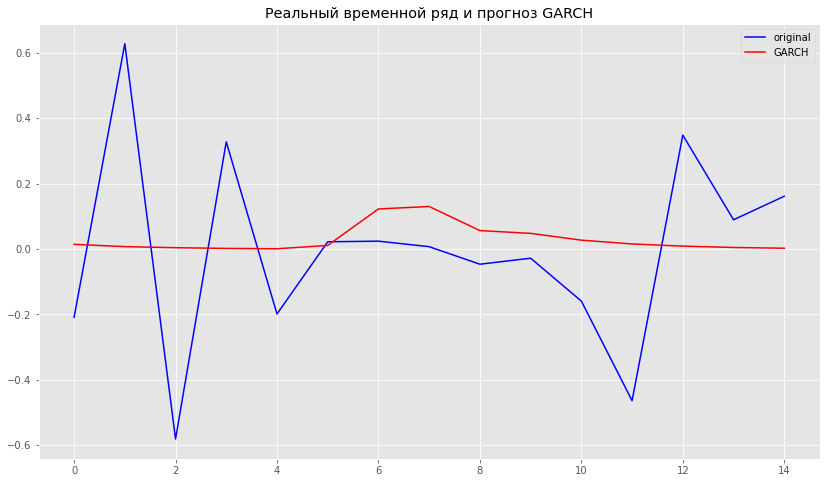

In [205]:
with plt.style.context("ggplot"):
    plt.figure(figsize=[14,8])
    plt.plot(test, color='blue', label='original')
    plt.plot(pred, color='red', label='GARCH')
    plt.title('Реальный временной ряд и прогноз GARCH')
    plt.legend()

In [207]:
mse = mean_squared_error(test, pred)
print('rmse=',np.sqrt(mse))

rmse= 0.3029938694703242


Модель GARCH оказалась хуже модели ARIMA с теми же параметрами.